# Placebo test

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices, dmatrix
import pymc as pm
import arviz as az

rng = np.random.default_rng(42)
figsize = (10, 5)
az.style.use("arviz-darkgrid")

In [3]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

pre_treatment_data = df.copy()
# 介入後ならば、対数人口を欠損値に変換
pre_treatment_data.loc[pre_treatment_data['after_treatment'] == 1, 'log_pop'] = np.nan
mean_t = pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop'].mean()
mean_c = pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop'].mean()
std_t = pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop'].std()
std_c = pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop'].std()

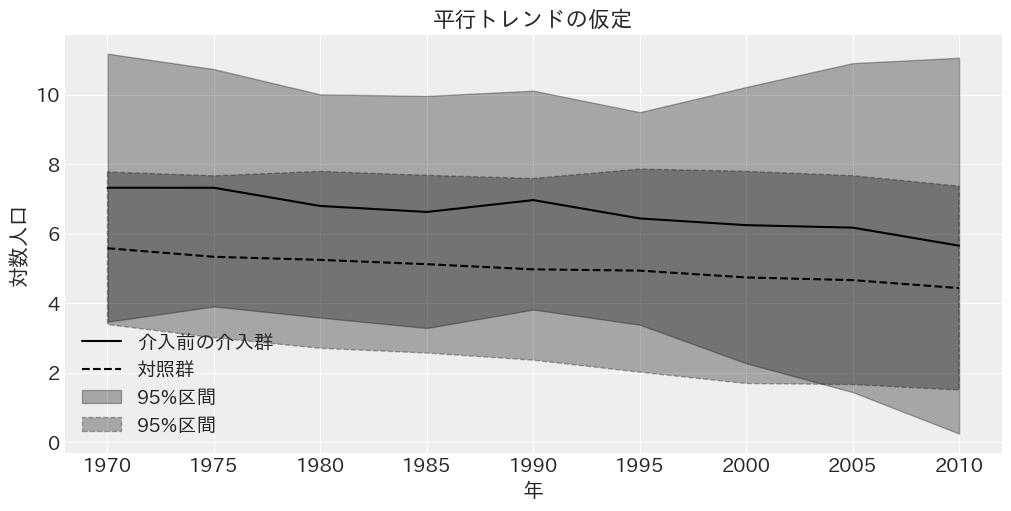

In [41]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(mean_t, label='介入前の介入群', color='black')
ax.plot(mean_c, label='対照群', color='black', linestyle='dashed')
ax.fill_between(mean_t.index, mean_t - 1.96 * std_t, mean_t + 1.96 * std_t, color='black', alpha=0.3, label='95%区間')
ax.fill_between(mean_c.index, mean_c - 1.96 * std_c, mean_c + 1.96 * std_c, color='black', linestyle='dashed', alpha=0.3, label='95%区間')
ax.legend()
ax.set_xlabel('年')
ax.set_ylabel('対数人口')
ax.set_title('平行トレンドの仮定')
plt.savefig('../../docs/figures/parallel_trend.png')

/tmp/ipykernel_35820/1714452081.py:3: UserWarning: 
The palette list has fewer values (1) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=pre_treatment_data.query('treatment_group == 1'), x='year', y='log_pop', hue='island_ids', ax=ax, palette=['black'], legend=False)


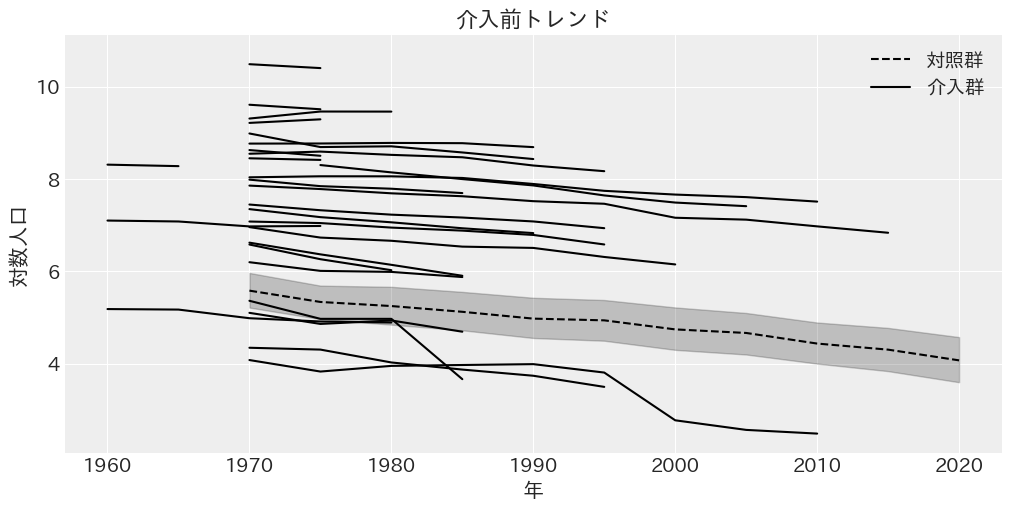

In [90]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=pre_treatment_data.query('treatment_group == 0'), x='year', y='log_pop', ax=ax, color='black', linestyle='dashed', label='対照群')
sns.lineplot(data=pre_treatment_data.query('treatment_group == 1'), x='year', y='log_pop', hue='island_ids', ax=ax, palette=['black'], legend=False)

# 装飾
ax.set_xlabel('年')
ax.set_ylabel('対数人口')
ax.set_title('介入前トレンド')

# 凡例の追加
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.lines[-1])
labels.append('介入群')
ax.legend(handles, labels)

## Post-trendの予測

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


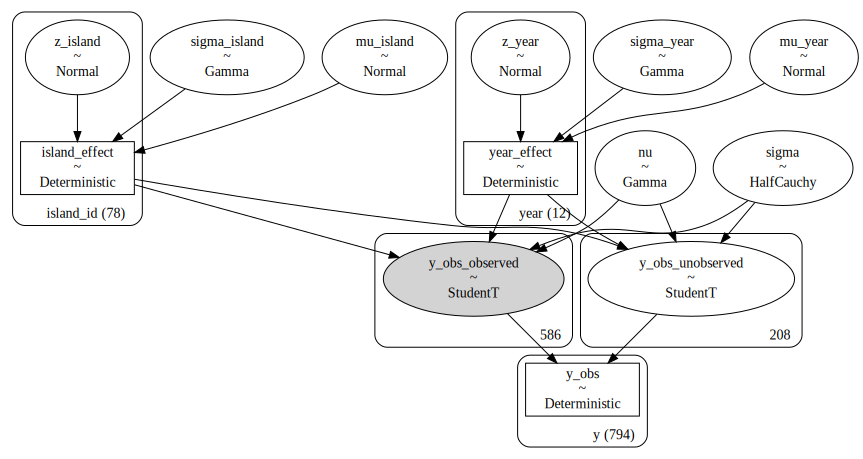

In [6]:
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
log_pop = pre_treatment_data['log_pop']

COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
}

with pm.Model(coords=COORDS) as post_trend:
    # prior
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma = pm.HalfCauchy('sigma', beta=1)

    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(post_trend)

In [7]:
with post_trend:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
az.summary(trace, var_names=['mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_island,6.437,0.235,5.994,6.861,0.011,0.008,425.0,1048.0,1.00
sigma_island,1.879,0.158,1.571,2.155,0.009,0.006,339.0,582.0,1.02
mu_year,-0.713,0.212,-1.123,-0.318,0.006,0.004,1316.0,2198.0,1.00
sigma_year,0.629,0.157,0.387,0.926,0.004,0.003,1636.0,2160.0,1.00
sigma,0.135,0.012,0.114,0.158,0.000,0.000,1101.0,1945.0,1.00
nu,2.338,0.395,1.634,3.027,0.014,0.010,822.0,1616.0,1.00


In [9]:
with post_trend:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

In [10]:
az.to_netcdf(trace, './mcmc_sample/post_trend.nc')

'./mcmc_sample/post_trend.nc'

In [66]:
y_pred_stacked = trace.posterior_predictive.y_obs.stack(sample=('chain', 'draw'))
y_pred = y_pred_stacked.mean(dim='sample')
pre_treatment_data['y_pred'] = y_pred
hdi = az.hdi(trace, hdi_prob=0.89).y_obs.values
pre_treatment_data['hdi_lwr'] = hdi[: ,0]
pre_treatment_data['hdi_upr'] = hdi[: ,1]
# 介入前の区間は 0
pre_treatment_data.loc[pre_treatment_data['after_treatment'] == 0, ['hdi_lwr', 'hdi_upr']] = np.nan

Text(0.5, 0, '年')

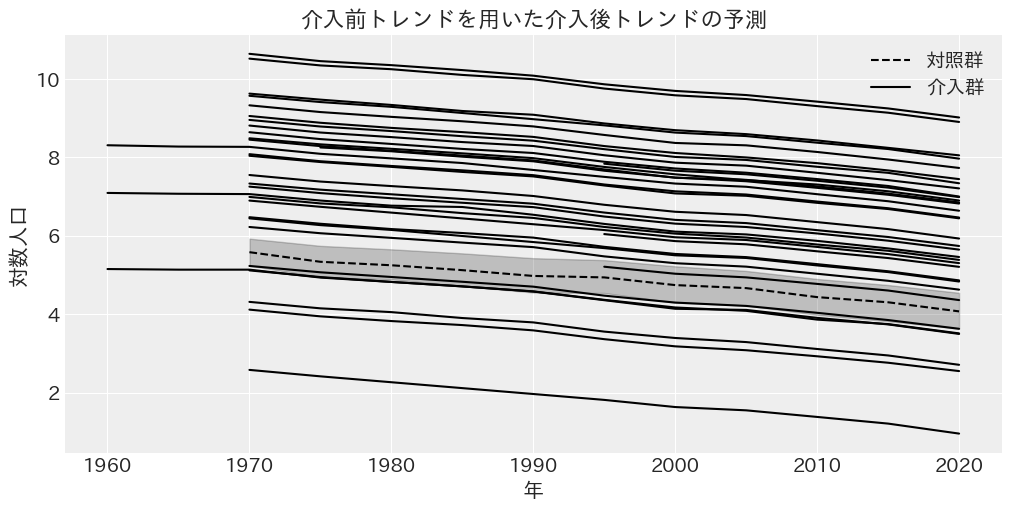

In [89]:
# island_id = 68

fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=pre_treatment_data.query('treatment_group == 0'), x='year', y='log_pop', ax=ax, color='black', linestyle='--', label='対照群')
for island_id in pre_treatment_data.query('treatment_group == 1')['island_ids'].unique():
    data_filter = pre_treatment_data.query(f'island_ids == {island_id}').sort_values('year')
    sns.lineplot(data=data_filter, x='year', y='y_pred', ax=ax, color='black', legend=False, linestyle='-')
    # ax.fill_between(
    #     x='year',
    #     y1='hdi_lwr',
    #     y2='hdi_upr',
    #     data=data_filter,
    #     color='black', alpha=0.1
    # )
# 凡例
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.lines[-1])
labels.append('介入群')
ax.legend(handles, labels)

# 装飾
ax.set_title('介入前トレンドを用いた介入後トレンドの予測')
ax.set_ylabel('対数人口')
ax.set_xlabel('年')